In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot, scatterplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import json
import pathlib

from scipy.linalg import norm
from scipy.optimize import minimize_scalar

In [2]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

In [34]:
# path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results_branch/')
path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results_osc/')
# path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results/')
# path = pathlib.Path('/media/storage_hdd3T/causal_opto_data/container_results_branch_osc_poisson/')

In [35]:
def read_json(fname):
    with open(str(fname), 'r') as f:
        params = json.load(f)
    return params

In [36]:
all_data = []
msds = []
# conn_fname = 'conditional_means_z-(2_1)_y(35_10).feather'
conn_fname = 'conditional_means_z-(2_1)_y(3_7).feather'

paths = sorted(
    [p for p in path.glob('results_*') if p.is_dir() and (p / conn_fname).exists()], 
    key=lambda x: int(x.stem.split('_')[-1])
)

for p in tqdm(paths):
    conn = pd.read_feather(p / conn_fname)
    assert conn.stim_amp_source.sum() != 0
    if len(all_data) > 1:
        assert conn.stim_amp_source.equals(all_data[0].stim_amp_source), p
        assert conn.weight.equals(all_data[0].weight), p
    n = p.stem.split('_')[-1]
    msd = read_json(list(p.glob('params*.json'))[0])['msd']
    assert msd not in msds
    msds.append(msd)
    all_data.append(conn)

HBox(children=(IntProgress(value=0, max=324), HTML(value='')))

In [37]:
def compute_means(df_list):
    keys = [
        'n_ref', 'hit_rate_source', 'hit_rate_target', 'y_ref', 
        'yb_ref', 'y_base', 'yb_base', 'y_respons', 'yb_respons'
    ]
    result = df_list[0].copy()
    for df in df_list[1:]:
        for k in keys:
            result[k] = result[k] + df[k]
    for k in keys[1:]:
        result[k] = result[k] / len(df_list)
    return result

In [38]:
def compute_values(df):
    df['beta_iv'] = df.y_respons - df.y_ref
    df['beta_iv_cor'] = df['beta_iv'] + df.yb_respons - df.yb_ref
    df['beta'] = df.y_respons - df.y_base
    df['beta_cor'] = df['beta'] - df.yb_respons + df.yb_base

In [39]:
conn = compute_means(all_data)
compute_values(conn)

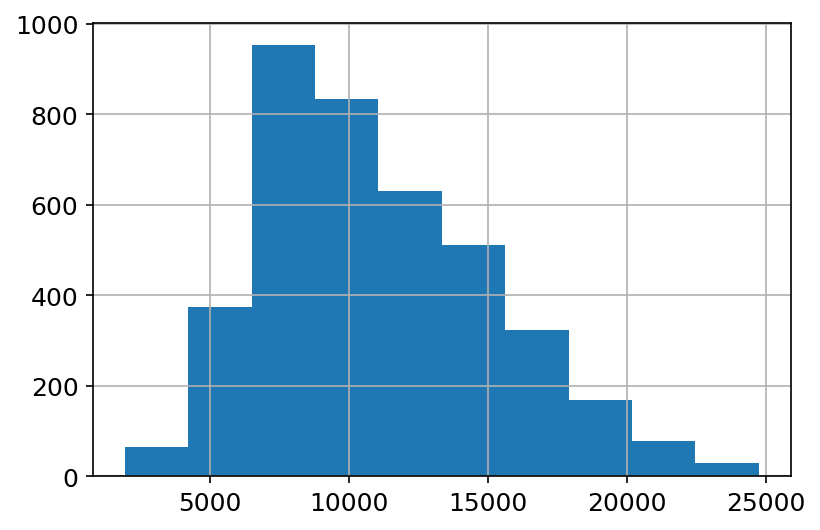

In [40]:
conn.n_ref.hist()
# plt.xlim(0,100000)

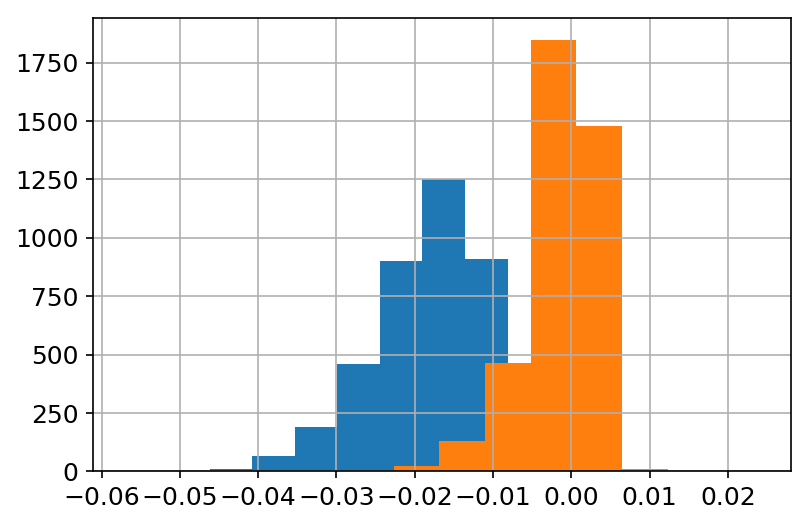

In [41]:
(conn.yb_respons - conn.yb_ref).hist()
(conn.yb_respons - conn.yb_base).hist()

# look at all

In [42]:
conn['wr'] = conn.query('weight > 0').weight.round(3)
sample = conn.drop_duplicates('wr')

# sample = sample.sample(2000)

In [43]:
len(sample)

1978

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

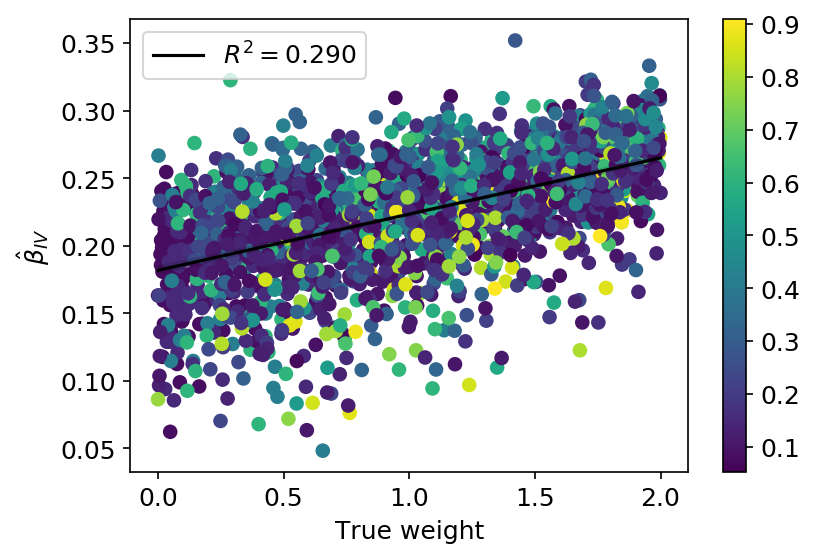

In [44]:
df_ = sample#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate_source'],
#     scatter_color=df_['n_ref'], 
    colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

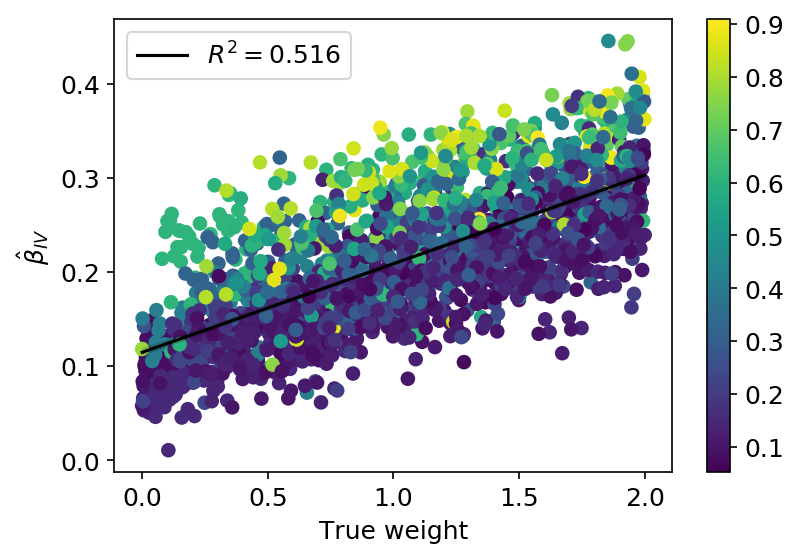

In [45]:
df_ = sample#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

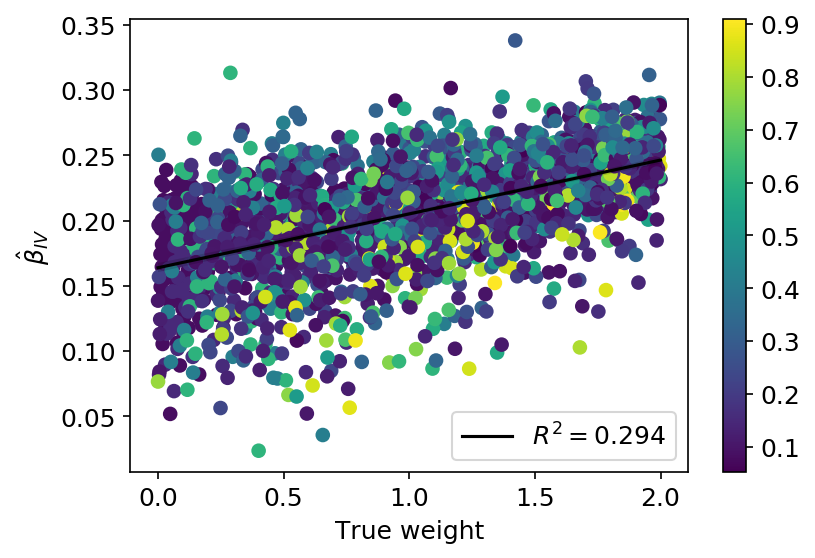

In [46]:
df_ = sample#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'beta_iv_cor', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

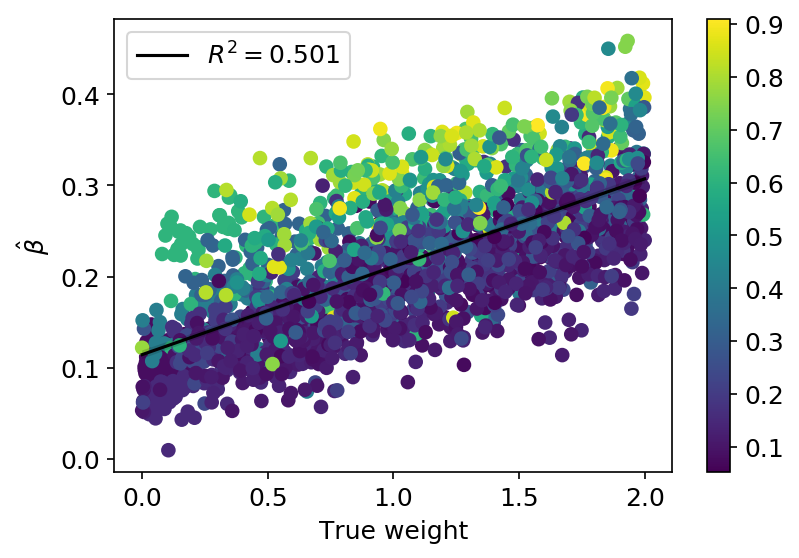

In [47]:
df_ = sample#.query('hit_rate > .1 and hit_rate < .9')
model = regplot(
    'weight', 'beta_cor', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'$\\hat{\\beta}$')

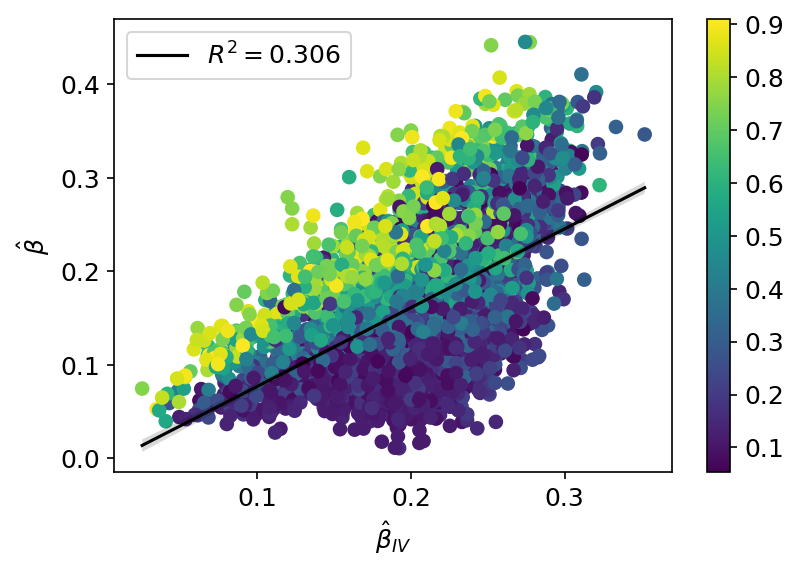

In [48]:
_df = conn
model = regplot(
    'beta_iv', 'beta', data=_df, 
    scatter_color=_df['hit_rate_source'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

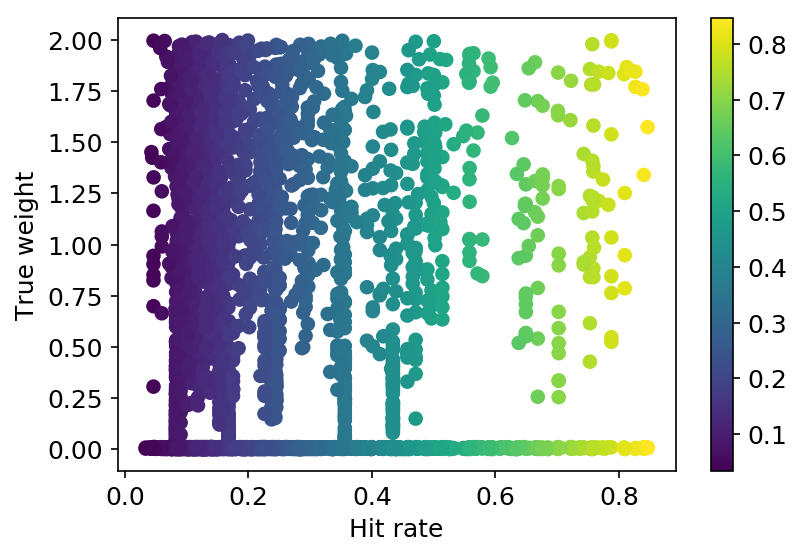

In [18]:
df_ = conn
scatterplot(
    'hit_rate_source', 'weight', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

Text(0,0.5,'True weight')

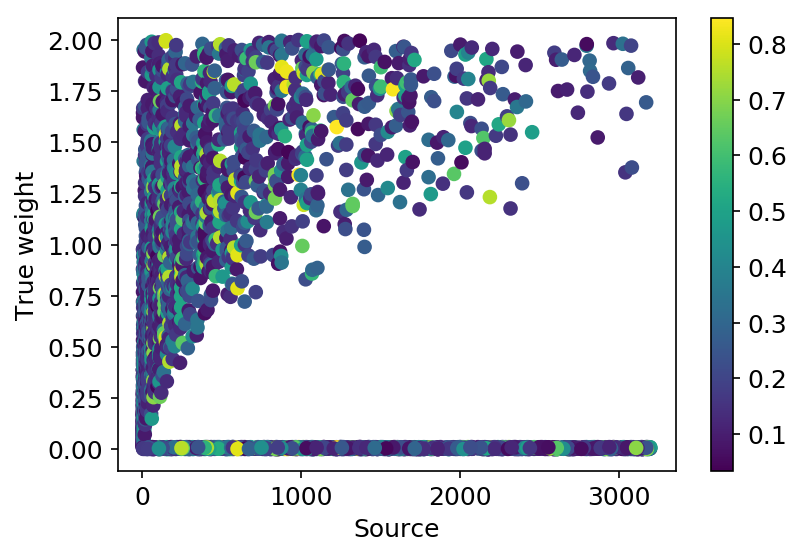

In [19]:
df_ = conn
scatterplot(
    'source', 'weight', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)


plt.xlabel('Source')
plt.ylabel('True weight')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

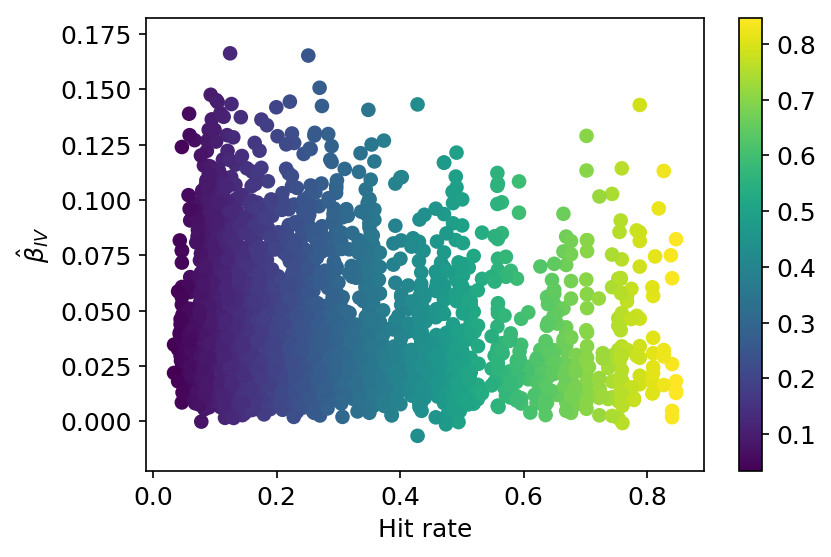

In [20]:
df_ = conn
scatterplot(
    'hit_rate_source', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

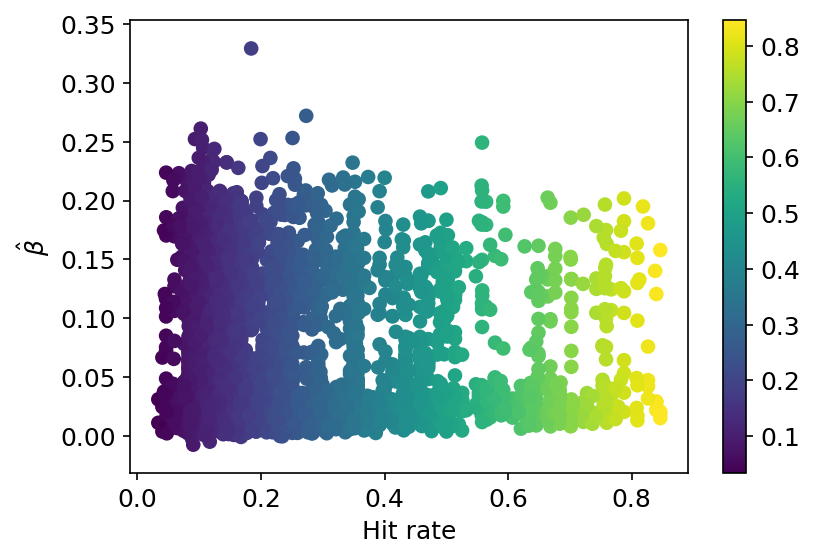

In [21]:
df_ = conn
scatterplot(
    'hit_rate_source', 'beta', data=df_, 
    scatter_color=df_['hit_rate_source'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0.5,0,'Stimulation amplitude')

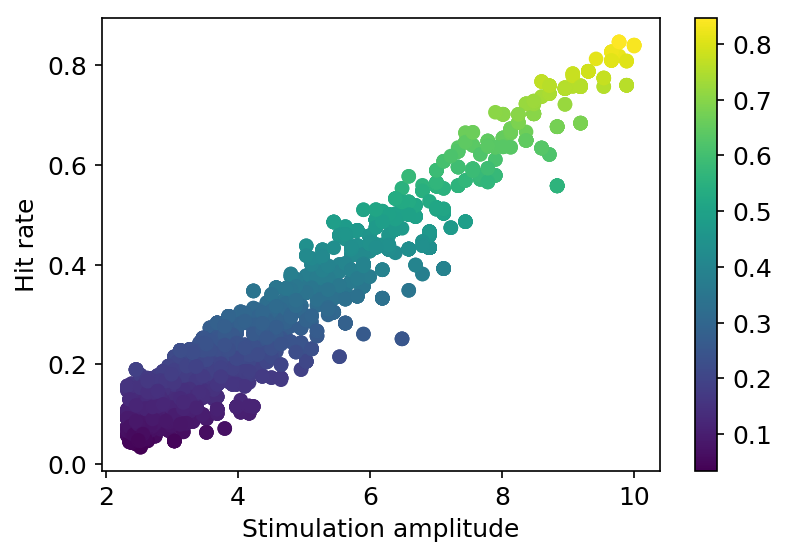

In [22]:
model = scatterplot(
    'stim_amp_source', 'hit_rate_source', data=conn, 
    scatter_color=conn['hit_rate_source'], colorbar=True)

plt.ylabel(r'Hit rate')
plt.xlabel(r'Stimulation amplitude')

# zero weight

In [23]:
query = 'weight < 0.01 and weight >= 0'
sample_zero = conn.query(query)

In [24]:
sample_zero.shape

(2000, 20)

([<matplotlib.axis.XTick at 0x7fd635789400>,
 <a list of 2 Text xticklabel objects>)

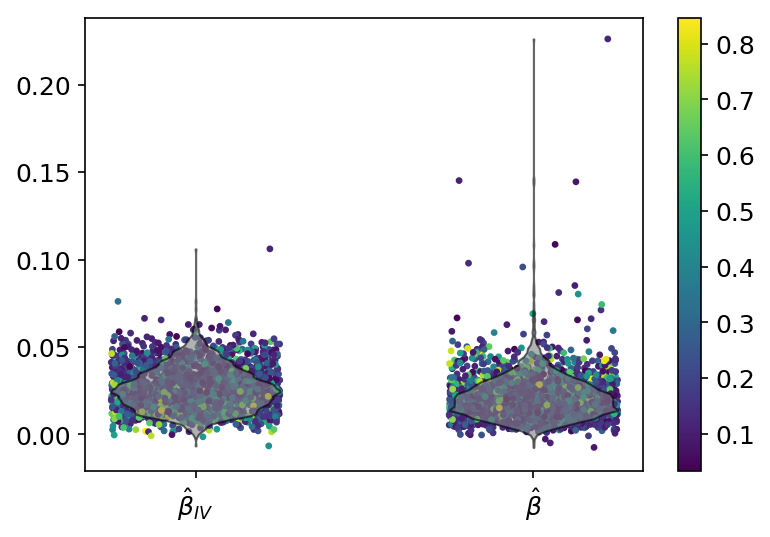

In [25]:
a = 'beta_iv'
fig, ax = plt.subplots(1, 1)
pos = np.random.uniform(.25,.75, size=len(sample_zero))
ax.scatter(pos + .5, sample_zero[a], c=sample_zero.hit_rate_source, s=5)
sc = ax.scatter(pos + 1.5, sample_zero['beta'], c=sample_zero.hit_rate_source, s=5)

cb = plt.colorbar(mappable=sc, ax=ax)
cb.ax.yaxis.set_ticks_position('right')

violins = plt.violinplot(sample_zero.loc[:, [a, 'beta']].T, showextrema=False, bw_method=0.1)
for pc in violins['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks([1, 2], [r'$\hat{\beta}_{IV}$', r'$\hat{\beta}$'])

# Error

In [26]:
def error(a, df, key):
    return norm(df['weight'] - a * df[key], ord=2)

def min_error(df, key):
    return minimize_scalar(error, args=(df, key)).fun

In [27]:
min_error(sample, 'beta')

11.155638554876232

In [28]:
minimize_scalar(error, args=(sample, 'beta_iv'))

     fun: 18.858375335127132
    nfev: 14
     nit: 9
 success: True
       x: 17.431674535559917

In [29]:
error(1, sample, 'beta_iv')

48.448765393752346

In [30]:
error(1, sample, 'beta')

45.81403146921867

In [31]:
err_beta = defaultdict(list)
err_beta_iv = defaultdict(list)
for i in tqdm(range(1, len(all_data))):
    df = compute_means(all_data[:i])
    compute_values(df)
    subd = df.loc[sample.index]
    err_beta['sample'].append(min_error(subd, 'beta'))
    err_beta_iv['sample'].append(min_error(subd, 'beta_iv'))
    
    subd = df.loc[sample_zero.index]
    err_beta['sample_zero'].append(error(1, subd, 'beta'))
    err_beta_iv['sample_zero'].append(error(1, subd, 'beta_iv'))

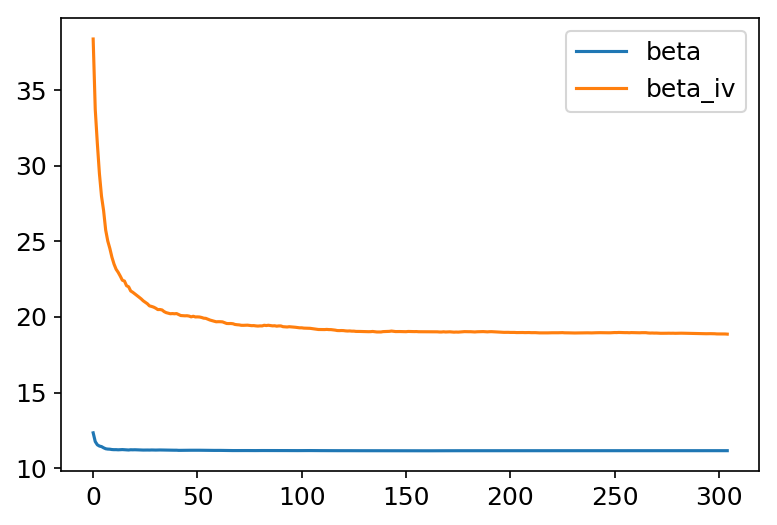

In [32]:
plt.plot(err_beta['sample'], label='beta')
plt.plot(err_beta_iv['sample'], label='beta_iv')
plt.legend()

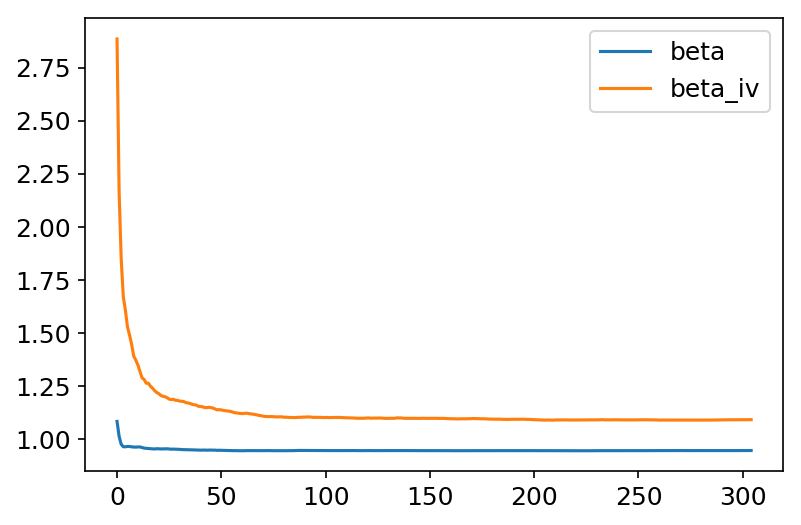

In [33]:
plt.plot(err_beta['sample_zero'], label='beta')
plt.plot(err_beta_iv['sample_zero'], label='beta_iv')
plt.legend()